# Part 0: Introduction

(Description of MITMH, how it works, /dev/joe's archive)

This is a project that I started about a year ago, but moved on from before doing any serious analysis - which I hope to remedy.

# Part 1: Gathering  & Storing Data

In [2]:
import urllib3
from bs4 import BeautifulSoup
import networkx as nx
from itertools import combinations 
import matplotlib.pyplot as plt

In [3]:
http = urllib3.PoolManager()
main_page = http.request('GET', 'https://devjoe.appspot.com/huntindex/index/puzzles.html')
soup = BeautifulSoup(main_page.data, 'html.parser')
links = soup.find_all('a')[2:-1]

In [ ]:
g = nx.Graph()
fh = open("mitmh_collab_edges.txt",'wb')

for i in links:
    puzzle_url = f"https://devjoe.appspot.com/huntindex{i['href'][2:]}"
    #print(puzzle_url)
    puzzle_page = http.request('GET', puzzle_url)
    soup_puzzle = BeautifulSoup(puzzle_page.data, 'html.parser') 
    puzzle_name = soup_puzzle.find('h2').text
    lines = soup_puzzle.find_all('p')
    for poss_line in lines:
        poss_line_text = poss_line.text
        if poss_line_text[:4] == "Hunt":
            hunt_name = poss_line_text.split(":")[1][1:-1]
        elif poss_line_text[:6] == "Author":
            authors = poss_line_text.split(":")[1].split(",")
            for (author1, author2) in combinations(authors, 2):
                g.add_edge(author1[1:], author2[1:], puzzle_name=puzzle_name, hunt_name=hunt_name)
                #print(f"{i['href']}:{author1}{author2}")
            break
        # TODO Extract keywords
#print(g.edges())

nx.write_edgelist(g, fh, delimiter=",")
fh.close()

# Part 2: Loading Data 

In [4]:
import networkx as nx
from itertools import combinations 
import matplotlib.pyplot as plt

fh = open("mitmh_collab_edges.txt",'rb')
G = nx.read_edgelist(fh,delimiter=",", comments="👍")
fh.close()

In [5]:
# Assign every hunt_name to an integer, then use that to create color map for edges
hunt_names = [e[2]["hunt_name"] for e in G.edges(data=True)]
#hunt_names = nx.get_edge_attributes(G,"hunt_name").values()
hunt_names_set = list(dict.fromkeys(hunt_names)) # like making a set, but keeps initial order
#print(hunt_names_set)
hunt_int_map = dict(zip(hunt_names_set, range(len(hunt_names_set))))
edge_colors = list(map(hunt_int_map.get, hunt_names))

# Part 3: Displaying Graphs

## Part 3.1: Displaying Using NetworkX

In [6]:
layout = nx.spring_layout(G,k=0.2,iterations=100)
#layout = nx.spectral_layout(G)

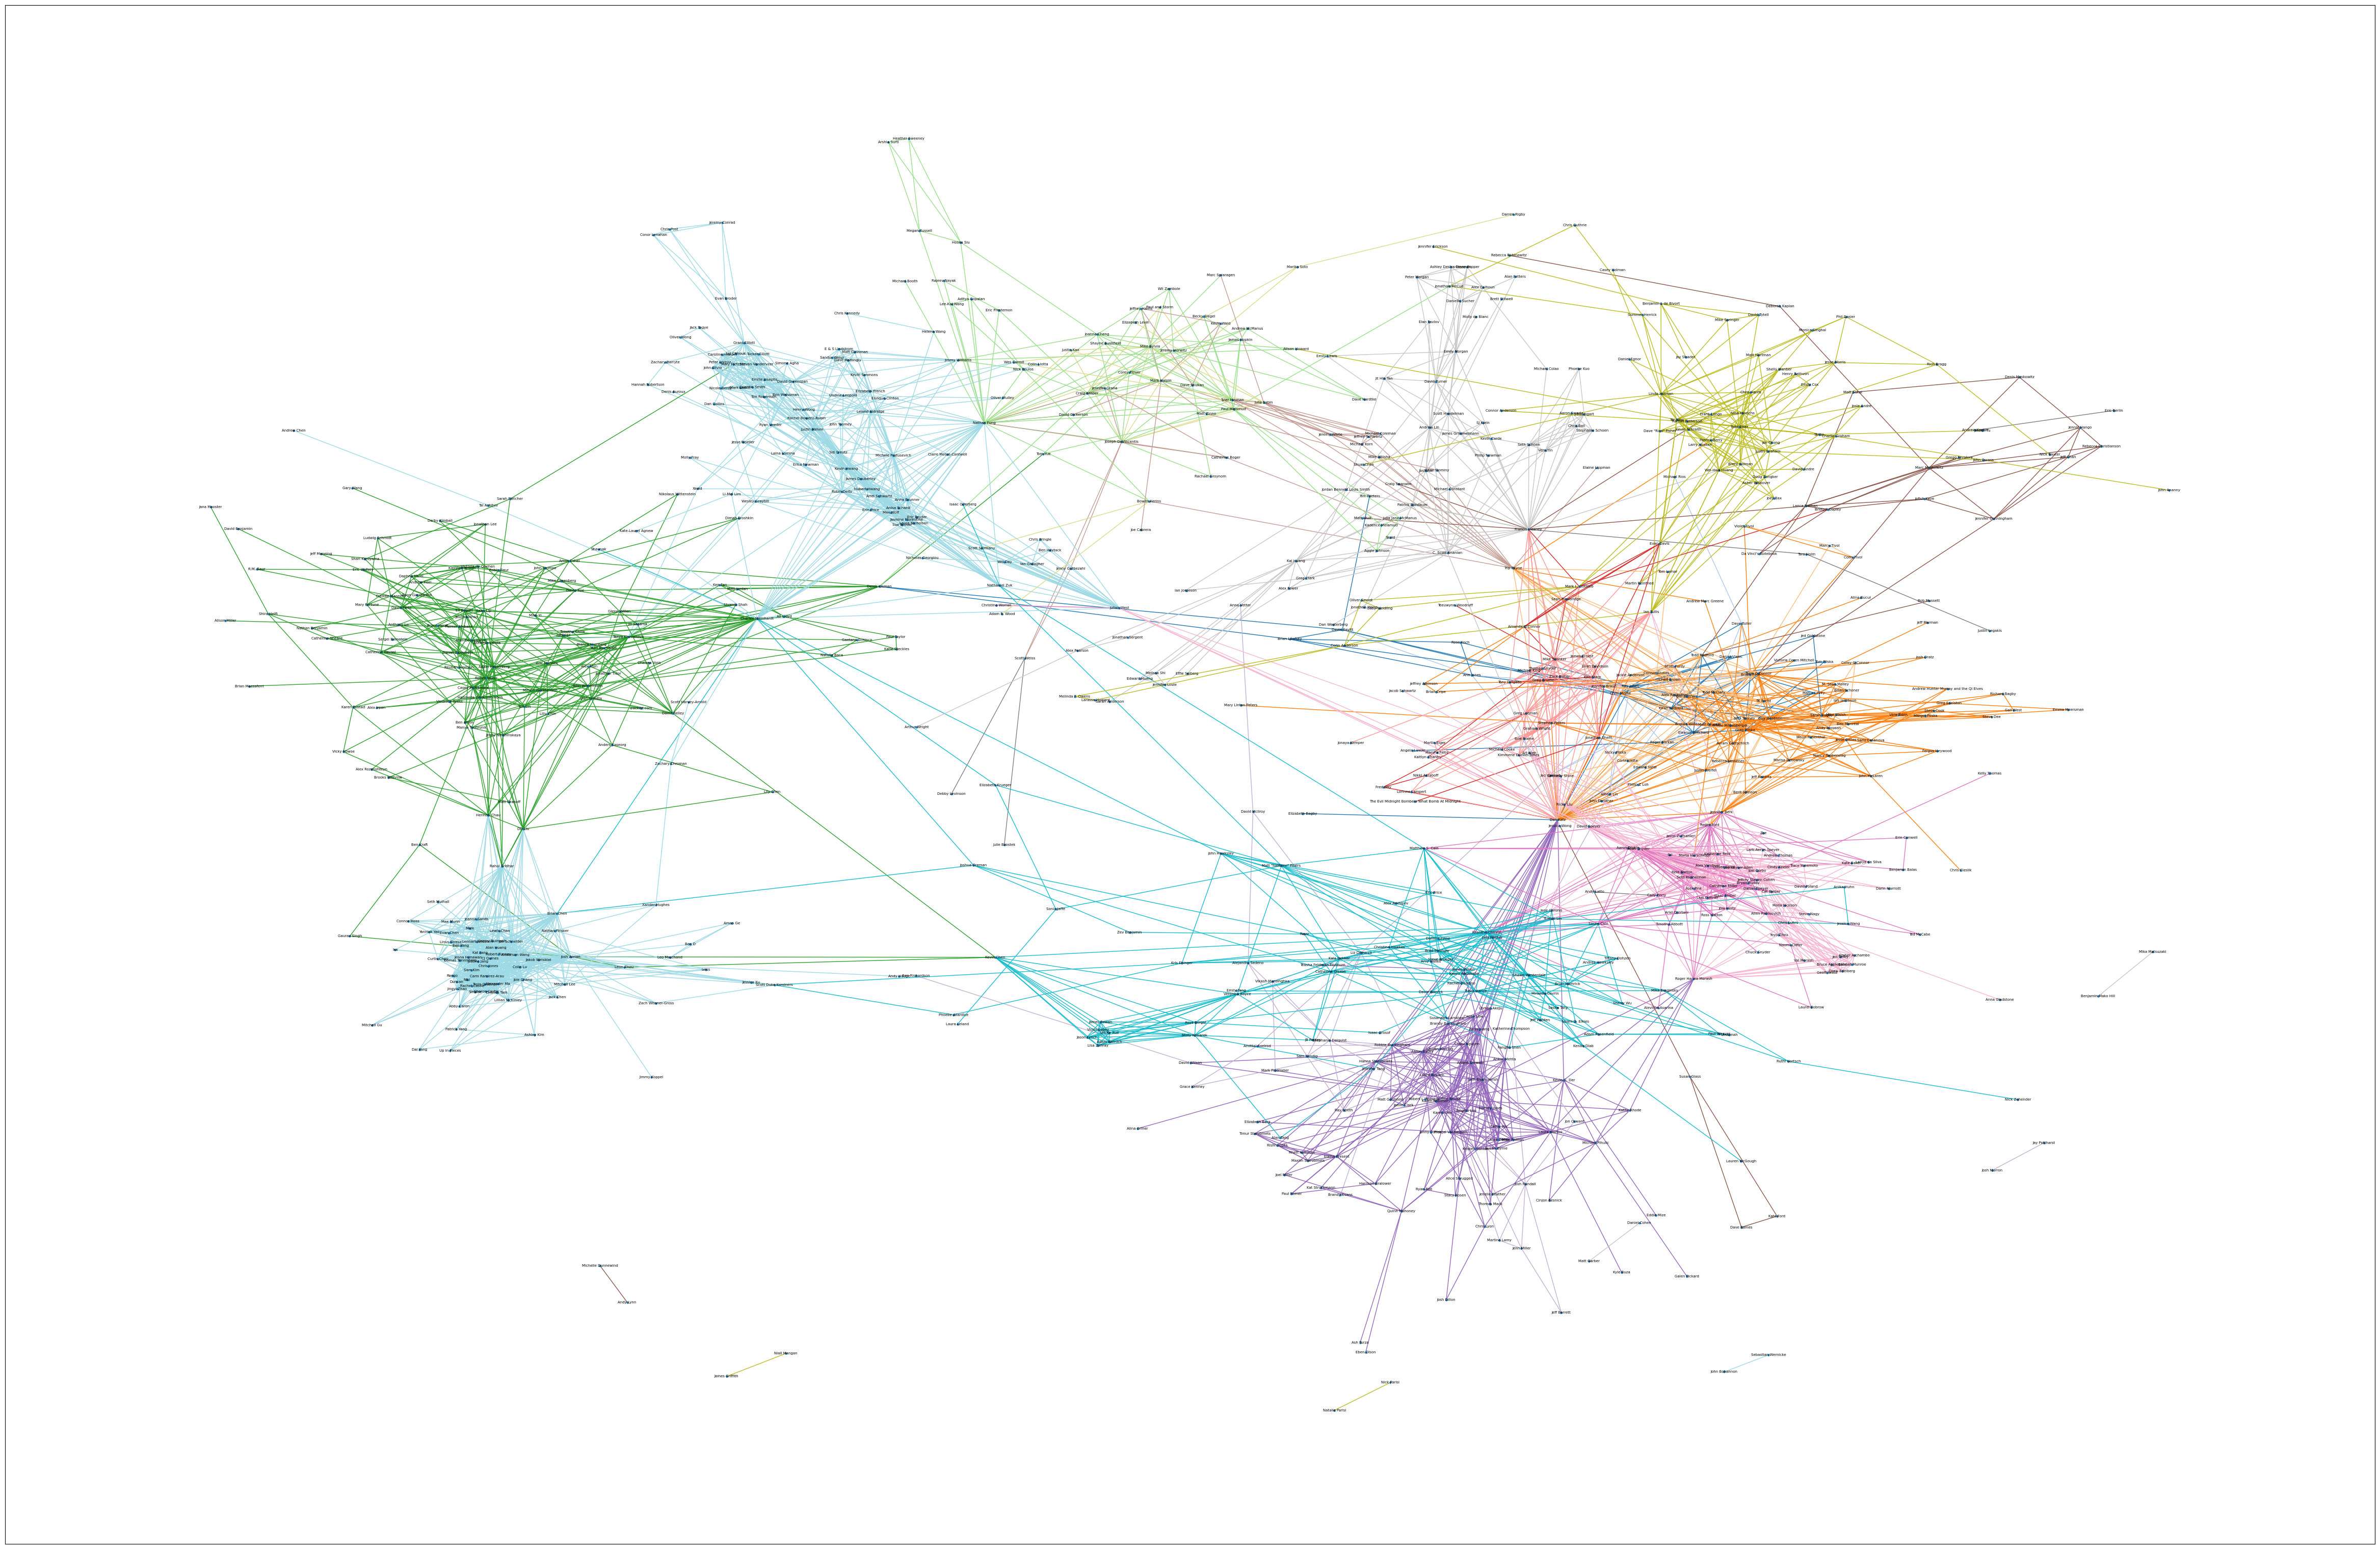

In [15]:
fig = plt.figure(num=None, figsize=(60, 40), dpi=100)

nx.draw_networkx_edges(G, pos=layout, width=1, edge_color=edge_colors, edge_cmap=plt.cm.tab20)
nx.draw_networkx_nodes(G, pos=layout, node_size=5)
nx.draw_networkx_labels(G, pos=layout, font_size=5)

plt.show()

# Hierarchical Network Visualization

In [16]:
fig.set_size_inches(60, 40)
fig.savefig('collab_graph.svg')
# fig.savefig('plot.png')

## Part 3.2: Interactive Graphs With Plotly Dash & Cytoscape

In [23]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html
import dash_cytoscape as cyto
from dash.dependencies import Input, Output
import plotly.express as px

In [28]:
nodes = [{'data': {'id': n, 'label': n}} for n in G.nodes()]
edges = [{'data': {'source': source, 'target': target, 
                   'puzzle_name': data['puzzle_name'], 'hunt_name': data['hunt_name']
         }}
         for source, target, data in G.edges(data=True)]

In [50]:
stylesheet=[
            {'selector': 'edge',
              'style': {
                'width': 3
              }
            },
            {'selector': 'node',
              'style': {
                'width': 5,
                'height': 5,
                'content': 'data(label)'
              }
            }
]

layout= {'name': 'cose',
         'animate': False, 
         'nodeDimensionsIncludeLabels': True,
         'idealEdgeLength': 20,
         'nodeOverlap': 50
        }

In [51]:
app = JupyterDash(__name__)

app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape-graph',
        layout=layout,
        style = {'width': '100%', 'height': '600px', 'font-size': '3pt'},
        stylesheet=stylesheet,
        elements=nodes+edges
    )
])

app.run_server(mode="inline")

# Part 3: Analysis

In [32]:
print(nx.info(G))
print("Density is %.2f" % nx.density(G))

Graph with 764 nodes and 3146 edges
Density is 0.01


The fact the density is so low means that the graph is very weakly connected. To get more detail, let's look at the distribution of degree between nodes:

<BarContainer object of 69 artists>

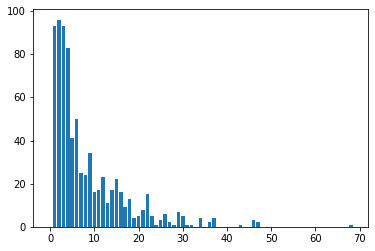

In [42]:
plt.bar(range(len(nx.degree_histogram(G))), nx.degree_histogram(G))

Unsurprisingly, there's a large tail -- most have collaborated with only a few other people, hence the reason that the graph is far from dense. But who are those super-stars which have collaborated large numbers of people?

In [39]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]

[('Dan Katz', 68),
 ('Josh Alman', 47),
 ('Jakob Weisblat', 47),
 ('Charles Steinhardt', 46),
 ('Nathan Fung', 46),
 ('Anderson Wang', 46),
 ('Greg Pliska', 43),
 ('Erin Rhode', 37),
 ('Brian Chen', 37),
 ('Colin Lu', 37),
 ('Justine Jang', 37),
 ('Francis Heaney', 36),
 ('Iolanthe Chronis', 36),
 ('Aaron Dinkin', 34),
 ('Sid Creutz', 34),
 ('Alan Huang', 34),
 ('Robert Tunney', 34),
 ('Robyn Speer', 32),
 ('Noah Snyder', 31),
 ("Tanis O'Connor", 30)]

We see that Dan Katz beats out all the other co-authors by a large margin.

It could be interesting to create a puzzle analogue to the [Bacon](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon#Bacon_numbers) or [Erdős number](https://en.wikipedia.org/wiki/Erd%C5%91s_number), measuring the length of the chain of co-authors necessary to get from a given person to Dan Katz.

In [ ]:
#TODO

## Part 3.1 Connectivity

We can see that most authors are connected in some way, but can we exactly how connected they are?

In [37]:
print(f"There are {nx.number_connected_components(G)} connected components:")
for component in nx.connected_components(G):
    comp_len = len(component)
    suffix = "..." if len(component) > 10 else ""
    print(f"One with {comp_len} nodes: {', '.join(list(component)[:min(10, comp_len)])}{suffix}")

There are 9 connected components:
One with 748 nodes: Edward Safdi, Andy Hauge, James Hopkin, Denis Moskowitz, Jit Hin Tan, Harrison Bralower, Dai Yang, Ryan Roe, Dan Katz, Simone...
One with 2 nodes: Eric Berlin, Andrew Kantor
One with 2 nodes: Michelle Dunnewind, Andy Lynn
One with 2 nodes: Josh Marron, Jay Pottharst
One with 2 nodes: Daniel Cohen, Matt Garber
One with 2 nodes: Benjamin Mako Hill, Mika Matsuzaki
One with 2 nodes: John Bohannon, Sebastian Wernicke
One with 2 nodes: James Griffith, Niall Mangan
One with 2 nodes: Nick Parisi, Natalie Parisi


We can see almost every person is part of the largest component; there are only 16 authors who are in their own components, with 8 puzzles as edges. What are these puzzles, and when were they written?

In [35]:
for component in nx.connected_components(G):
    if len(component) == 2:
        print(G[list(component)[0]][list(component)[1]])

{'puzzle_name': 'Kakorrhaphiophobia!', 'hunt_name': 'MIT Mystery Hunt 2001'}
{'puzzle_name': 'Shredded What?', 'hunt_name': 'MIT Mystery Hunt 2003'}
{'puzzle_name': 'Noise in the Air', 'hunt_name': 'MIT Mystery Hunt 2004'}
{'puzzle_name': 'Google Bodyslam', 'hunt_name': 'MIT Mystery Hunt 2012'}
{'puzzle_name': 'Written Down', 'hunt_name': 'MIT Mystery Hunt 2012'}
{'puzzle_name': 'Cooking a Recipe', 'hunt_name': 'MIT Mystery Hunt 2018'}
{'puzzle_name': 'Snow Job', 'hunt_name': 'MIT Mystery Hunt 2020'}
{'puzzle_name': 'Fountain Show', 'hunt_name': 'MIT Mystery Hunt 2020'}


I thought that most of these would be from the earlier hunts, but surprisingly they seem to be spread fairly well across the time span captured by the data.

## Part 3.3 Communities

What are the *communities* in this graph -- i.e. which portions of it are densely connected among themselves? Do these match the clusters of people who wrote puzzles for the same hunt?

## Simplifying The Graphs

As you can see, these graphs are really hard to read because of the sheer number of nodes and edges. One idea I  had to minimize this was take the clusters of people who have only collaborated with other individuals on a single hunt and collapse each of them into a single node. We can thus easily see who connects these components (i.e. those that have collaborated on multiple hunts). 

In [ ]:
#TODO

We can then look at the collaboration graph for each year individually:

In [ ]:
#TODO